#### imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from fitting_functions import *
import pickle
from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

## Load in data
test_index = 5   
snr = Vhi_Alo + asynchrony


In [2]:
PLOT_RANGE = 8
ALPHA = 0.3
FONTSIZE= 10
TEXT_Y = [0.35,0.4,0.48]

test_index = 5
snr_type = 4
synch_type = 1
synch_names = ['synch','asynch']
snrs_names= ['Vhi_Ahi','Vmid_Ahi','Vlo_Ahi','Vhi_Amid','Vhi_Alo']
print('tester index:{}\tsnr:{}\tsynch:{}'.format(test_index,snrs_names[snr_type],synch_names[synch_type]))

fitted_param_path_bci = '../fitted_params/fitted_params_bci_full_1.npy'
fitted_param_path_jpm = '../fitted_params/fitted_params_jpm_full_1.npy'
params_stored_bci = np.load(fitted_param_path_bci)
params_stored_jpm = np.load(fitted_param_path_jpm)
# print(fitted_param_path_bci.shape)
print('bci parameters from :{}'.format(fitted_param_path_bci))
print('jpm parameters from :{}'.format(fitted_param_path_jpm))

pkl_path = '../S2_data/data.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)


x0 = params_stored_bci[test_index,:]
p_s,p_a = x0[0:2]
[mu_vg, mu_vb, mu_ag, mu_ab] = x0[2:6]
[sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al] = x0[6:12]
c = x0[12:]

x0_jpm = params_stored_jpm[test_index,:]
sigma_0_s,sigma_0_a = x0_jpm[0:2]
[mu_vg_jpm, mu_vb_jpm, mu_ag_jpm, mu_ab_jpm] = x0_jpm[2:6]
[sigma_vh_jpm, sigma_vm_jpm, sigma_vl_jpm, sigma_ah_jpm, sigma_am_jpm, sigma_al_jpm] = x0_jpm[6:12]
c_jpm = x0_jpm[12:]


tester index:5	snr:Vhi_Alo	synch:asynch
bci parameters from :../fitted_params/fitted_params_bci_full_1.npy
jpm parameters from :../fitted_params/fitted_params_jpm_full_1.npy


In [3]:
# BCI
mus_pc1, sigmas_pc1 = get_params_AV(mu_ab, mu_vg, sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al,
                                sigma_0=0)
mus_pc2, sigmas_pc2 = get_params_AV(mu_ab, mu_vg, sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al,
                                        sigma_0=np.inf)



res_prob_pc1 = guassian2prob(mus_pc1, sigmas_pc1, c)
res_prob_pc2 = guassian2prob(mus_pc2, sigmas_pc2, c)

res_prob_s = p_s*res_prob_pc1 + (1-p_s)*res_prob_pc2
res_prob_a = p_a*res_prob_pc1 + (1-p_a)*res_prob_pc2


# JPM
mus_jpm_s, sigmas_jpm_s = get_params_AV(mu_ab_jpm, mu_vg_jpm, sigma_vh_jpm, sigma_vm_jpm,
                                sigma_vl_jpm, sigma_ah_jpm, sigma_am_jpm,
                                sigma_al_jpm,
                                sigma_0=sigma_0_s)
mus_jpm_a, sigmas_jpm_a = get_params_AV(mu_ab_jpm, mu_vg_jpm, sigma_vh_jpm, sigma_vm_jpm,
                                sigma_vl_jpm, sigma_ah_jpm, sigma_am_jpm,
                                sigma_al_jpm,
                                sigma_0=sigma_0_a)
res_prob_jpm_s = guassian2prob(mus_jpm_s, sigmas_jpm_s, c_jpm)
res_prob_jpm_a = guassian2prob(mus_jpm_a, sigmas_jpm_a, c_jpm)


### plot the 2 distrubution out

Text(0.5, 1.0, 'tester index:5\nsnr:Vhi_Alo, synch:asynch')

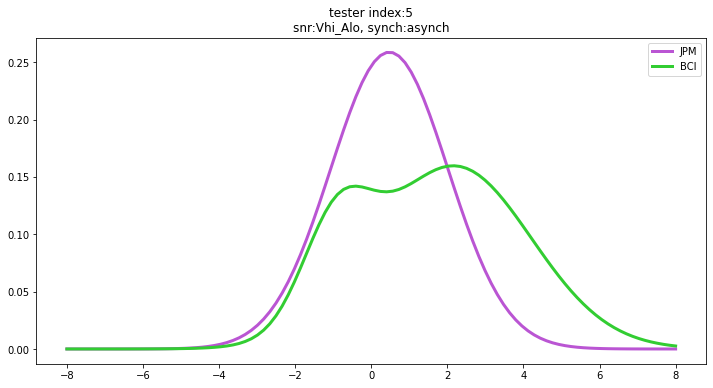

In [4]:
plt.figure(figsize=(12,6))

j=synch_type

if j == 0:
    mus_jpm = mus_jpm_s
    sigmas_jpm = sigmas_jpm_s
    res_prob_jpm = res_prob_jpm_s
    ori_prob = np.array(data['AVFus']['synch']['props'][test_index, :, :])
    p = p_s
    # title_str = sub_plot_title[i]+' synchrony'
    res_prob = res_prob_s
else:
    mus_jpm = mus_jpm_a
    sigmas_jpm = sigmas_jpm_a
    res_prob_jpm = res_prob_jpm_a
    ori_prob = np.array(data['AVFus']['asynch']['props'][test_index, :, :])
    p = p_a
    # title_str = sub_plot_title[i]+' asynchrony'
    res_prob = res_prob_a

xs = np.linspace(-PLOT_RANGE,PLOT_RANGE,100)
plt.plot(xs, stats.norm.pdf(xs, mus_jpm[snr_type], sigmas_jpm[snr_type]),
               color='mediumorchid', linewidth=3, label='JPM')
plt.plot(xs, p*stats.norm.pdf(xs, mus_pc1[snr_type], sigmas_pc1[snr_type])+
                      (1-p)*stats.norm.pdf(xs, mus_pc2[snr_type], sigmas_pc2[snr_type]),
                    color='limegreen',linewidth=3,label='BCI')


# generating samples




# plt.xlim(-5,8)
plt.legend()
plt.title('tester index:{}\nsnr:{}, synch:{}'.format(test_index,snrs_names[snr_type],synch_names[synch_type]))

## Generate stimulated data

In [5]:
sample_size = 25


In [6]:
# sample the BCI distribution
distributions = [
    {"type": np.random.normal, "kwargs": {"loc": mus_pc1[snr_type], "scale":sigmas_pc1[snr_type]}},
    {"type": np.random.normal, "kwargs": {"loc": mus_pc2[snr_type], "scale": sigmas_pc2[snr_type]}},
]
coefficients = np.array([p,1-p])
coefficients /= coefficients.sum()      # in case these did not add up to 1

num_distr = len(distributions)
data_ = np.zeros((sample_size, num_distr))
for idx, distr in enumerate(distributions):
    data_[:, idx] = distr["type"](size=(sample_size,), **distr["kwargs"])
random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
sample_bci = data_[np.arange(sample_size), random_idx]


In [7]:
# sample the JPM distribution
sample_jpm = np.random.normal(mus_jpm[snr_type], sigmas_jpm[snr_type], sample_size)

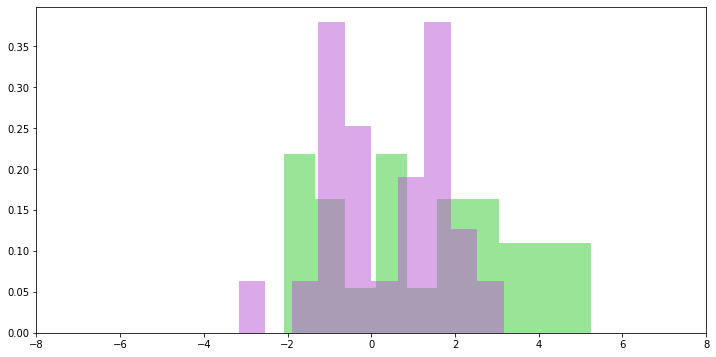

In [8]:
plt.figure(figsize=(12,6))
plt.hist(sample_bci, density=True,color='limegreen',alpha=0.5)
plt.hist(sample_jpm, density=True,color='mediumorchid',alpha=0.5)
# plt.vlines(c_jpm[0],0,0.5,color='purple')
# plt.vlines(c_jpm[1],0,0.5,color='purple')
# plt.vlines(c[0],0,0.5,color='green')
# plt.vlines(c[1],0,0.5,color='green')
plt.xlim(-PLOT_RANGE,PLOT_RANGE)
plt.show()

#### The distribution of audio stimuli

Text(0.5, 1.0, 'tester index:5\nsnr:Vhi_Alo, synch:asynch')

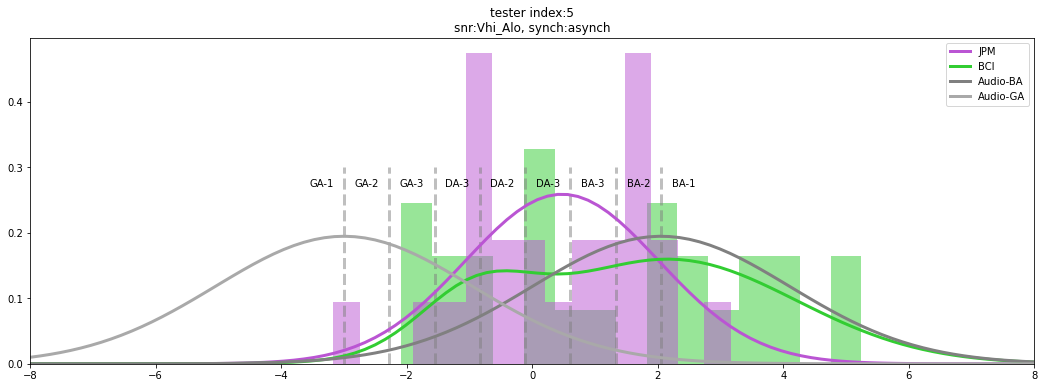

In [9]:
plt.figure(figsize=(18,6))

j=synch_type

if j == 0:
    mus_jpm = mus_jpm_s
    sigmas_jpm = sigmas_jpm_s
    res_prob_jpm = res_prob_jpm_s
    ori_prob = np.array(data['AVFus']['synch']['props'][test_index, :, :])
    p = p_s
    # title_str = sub_plot_title[i]+' synchrony'
    res_prob = res_prob_s
else:
    mus_jpm = mus_jpm_a
    sigmas_jpm = sigmas_jpm_a
    res_prob_jpm = res_prob_jpm_a
    ori_prob = np.array(data['AVFus']['asynch']['props'][test_index, :, :])
    p = p_a
    # title_str = sub_plot_title[i]+' asynchrony'
    res_prob = res_prob_a

xs = np.linspace(-PLOT_RANGE,PLOT_RANGE,100)
plt.plot(xs, stats.norm.pdf(xs, mus_jpm[snr_type], sigmas_jpm[snr_type]),
               color='mediumorchid', linewidth=3, label='JPM')
plt.plot(xs, p*stats.norm.pdf(xs, mus_pc1[snr_type], sigmas_pc1[snr_type])+
                      (1-p)*stats.norm.pdf(xs, mus_pc2[snr_type], sigmas_pc2[snr_type]),
                    color='limegreen',linewidth=3,label='BCI')

# plot the distribution for audio stimuli
plt.plot(xs,stats.norm.pdf(xs, mu_ab_jpm, sigma_al_jpm),color = 'grey', linewidth=3, label='Audio-BA')
plt.plot(xs,stats.norm.pdf(xs, mu_ag_jpm, sigma_al_jpm),color = 'darkgrey', linewidth=3, label='Audio-GA')

# set the boundries
boundaries = np.linspace(mu_ag_jpm,mu_ab_jpm,8)
span = boundaries[1]-boundaries[0]
b_texts= ['GA-1','GA-2','GA-3','DA-3','DA-2','DA-3','BA-3','BA-2','BA-1']
# print(mu_ag_jpm,mu_ab_jpm)
# print(boundaries)
ymin = 0
ymax = 0.3
for i in range(8):
    plt.vlines(boundaries[i],ymin=ymin,ymax=ymax,color='grey', alpha = 0.5,linewidth=3,linestyle = 'dashed')
    plt.text(boundaries[i]-span/2,ymax-0.03,s=b_texts[i],ha='center',fontsize=10)
    if i == 7:
        plt.text(boundaries[i]+span/2,ymax-0.03,s=b_texts[i+1],ha='center',fontsize=10)


# # samples
bins = 15
plt.hist(sample_bci,bins=bins, density=True,color='limegreen',alpha=0.5)
plt.hist(sample_jpm,bins=bins, density=True,color='mediumorchid',alpha=0.5)



plt.xlim(-8,8)
plt.legend()
plt.title('tester index:{}\nsnr:{}, synch:{}'.format(test_index,snrs_names[snr_type],synch_names[synch_type]))

prob for each class(9 classes)   
**Key problem**: how to prove the two probs are dissimilar/similar


##### Step 1: get the prob for each confidence level

In [10]:
def sample2count(samples,boundaries):
    # extend boundaries
    boundaries = np.insert(boundaries,0,-np.inf)
    boundaries = np.insert(boundaries,len(boundaries),np.inf)
#     print(boundaries)
    
    counts = np.zeros(len(boundaries)-1)
    for each_s in samples:
        assign2class = 0
        for i in range(len(boundaries)-1):
            if each_s > boundaries[i] and each_s < boundaries[i+1]:
                counts[i]+=1
                break
            
            
    return counts         
            

In [11]:
# c = sample2prob(sample_jpm,boundaries)
# print(c)
# print(np.sum(c))

In [12]:
probs_jpm = sample2count(sample_jpm,boundaries)/sample_size
probs_bci = sample2count(sample_bci,boundaries)/sample_size
print('the boundaries:{}'.format(b_texts))
print('probs_jpm={}\nprobs_bci={}'.format(probs_jpm,probs_bci))

the boundaries:['GA-1', 'GA-2', 'GA-3', 'DA-3', 'DA-2', 'DA-3', 'BA-3', 'BA-2', 'BA-1']
probs_jpm=[0.04 0.   0.04 0.12 0.24 0.08 0.16 0.24 0.08]
probs_bci=[0.   0.   0.12 0.12 0.04 0.16 0.08 0.08 0.4 ]


##### Method 1: compute the d_prime as the sensitvity

In [13]:
noise_sample = sample_jpm
signal_sample = sample_bci

In [14]:
p_fa = [np.sum(noise_sample > b)/sample_size for b in boundaries]
p_hit = [np.sum(signal_sample > b)/sample_size  for b in boundaries]

In [15]:
inv_p_hit = [norm.ppf(p_h) for p_h in p_hit]
inv_p_fa = [norm.ppf(p_f) for p_f in p_fa]

In [16]:
print(inv_p_hit,inv_p_fa)
print(boundaries)

[inf, inf, 1.1749867920660904, 0.7063025628400874, 0.5828415072712162, 0.1509692154967774, -0.05015358346473367, -0.2533471031357997] [1.7506860712521692, 1.7506860712521692, 1.4050715603096329, 0.8416212335729143, 0.1509692154967774, -0.05015358346473367, -0.46769879911450823, -1.4050715603096329]
[-2.99999897 -2.27844393 -1.5568889  -0.83533386 -0.11377882  0.60777622
  1.32933126  2.0508863 ]


###### Fit it with a line
fixed the a as 1.0, b is equal to d'then

In [17]:
# 
def func(x, a, b):
        return a * x + b

# fix a as 1.0
a_fixed = 1.0

# remove the inv_p with inf
index_,index_fa,index_hit = 0,0,0
for i in range(len(inv_p_fa)):
    if inv_p_fa[i] != np.inf:
        index_fa = i
        break
for j in range(len(inv_p_hit)):
    if inv_p_hit[j] != np.inf:
        index_hit = j
        break
index_ = index_hit if index_hit>=index_fa else index_fa

inv_p_fa_new = inv_p_fa[index_:]
inv_p_hit_new = inv_p_hit[index_:]
    

popt, pcov = curve_fit(lambda x, b: func(x, a_fixed, b), inv_p_fa_new, inv_p_hit_new)
print('fixed a = 1.0, fitted b = {}'.format(*popt))

fixed a = 1.0, fitted b = 0.30614355409568417


In [18]:
# reverse noise and signal
noise_sample = sample_bci
signal_sample = sample_jpm
p_fa_r = [np.sum(noise_sample > b)/sample_size for b in boundaries]
p_hit_r = [np.sum(signal_sample > b)/sample_size  for b in boundaries]
inv_p_hit_r = [norm.ppf(p_h) for p_h in p_hit_r]
inv_p_fa_r = [norm.ppf(p_f) for p_f in p_fa_r]

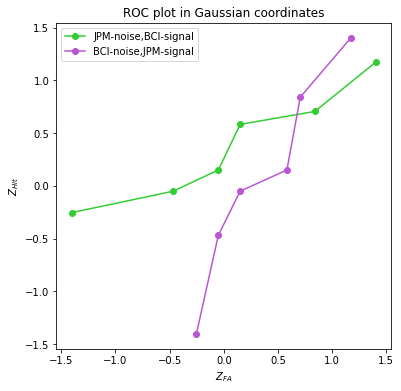

In [19]:
plt.figure(figsize=(6,6))
plt.plot(inv_p_fa,inv_p_hit,color = 'limegreen',marker='o',label='JPM-noise,BCI-signal')
plt.plot(inv_p_fa_r,inv_p_hit_r,color= 'mediumorchid',marker='o',label='BCI-noise,JPM-signal')
plt.title('ROC plot in Gaussian coordinates')
plt.xlabel('$Z_{FA}$')
plt.ylabel('$Z_{Hit}$')
plt.legend()
plt.show()

#### Run the trails for 100 times for each sample size and get the following table

| sample size | mean of d'| var of d'| 
|:------:|:-----:|:----:|
|25|0.2988|0.3307|
|50|0.2879|0.2152|
|100|0.3398|0.1726|
|200|0.2954|0.1175|
|500|0.3105|0.1041|
|1000|0.3055|0.0542|
|10000|0.3030|0.0185|


In [20]:
def generate_sample(sample_size,
                    # BCI parameters
                    mus_pc1,mus_pc2,sigmas_pc1,sigmas_pc2,snr_type,p,
                   # JPM parameters
                   mus_jpm,sigmas_jpm):
    
    # sample the BCI distribution
    distributions = [
        {"type": np.random.normal, "kwargs": {"loc": mus_pc1[snr_type], "scale":sigmas_pc1[snr_type]}},
        {"type": np.random.normal, "kwargs": {"loc": mus_pc2[snr_type], "scale": sigmas_pc2[snr_type]}},
    ]
    coefficients = np.array([p,1-p])
    coefficients /= coefficients.sum()      # in case these did not add up to 1

    num_distr = len(distributions)
    data_ = np.zeros((sample_size, num_distr))
    for idx, distr in enumerate(distributions):
        data_[:, idx] = distr["type"](size=(sample_size,), **distr["kwargs"])
    random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
    sample_bci = data_[np.arange(sample_size), random_idx]
    
    # sample the JPM distribution
    sample_jpm = np.random.normal(mus_jpm[snr_type], sigmas_jpm[snr_type], sample_size)
    
    return (sample_bci,sample_jpm)


In [21]:
def sample2counts(samples,boundaries):
    # extend boundaries
    boundaries = np.insert(boundaries,0,-np.inf)
    boundaries = np.insert(boundaries,len(boundaries),np.inf)
#     print(boundaries)
    
    counts = np.zeros(len(boundaries)-1)
    for each_s in samples:
        assign2class = 0
        for i in range(len(boundaries)-1):
            if each_s > boundaries[i] and each_s < boundaries[i+1]:
                counts[i]+=1
                break
            
            
    return counts         
            

In [22]:
def get_boundaries(mu_ag_jpm,mu_ab_jpm,seperate_parts = 9):
    boundaries = np.linspace(mu_ag_jpm,mu_ab_jpm,seperate_parts-1)
    return boundaries

In [23]:
def remove_inf(list_1,list_2):
    #print(list_1,list_2)
    # begining
    index_,index_1,index_2 = 0,0,0
    for i in range(len(list_1)):
        if list_1[i] != np.inf:
            index_1 = i
            break
    for j in range(len(list_2)):
        if list_2[j] != np.inf:
            index_2 = j
            break
            
    index_ = index_1 if index_1 >=index_2 else index_2

    list_1_new = list_1[index_:]
    list_2_new = list_2[index_:]

    # at the end
    index_,index_1,index_2 = len(list_1_new),len(list_1_new),len(list_1_new)
    for i in range(len(list_1_new)):
        if list_1_new[i] == np.inf:
            index_1 = i
            break
    for j in range(len(list_2_new)):
        if list_2_new[j] == np.inf:
            index_2 = j
            break
            
    index_ = index_1 if index_1 <=index_2 else index_2
    #print(list_1,list_2)
    #print(index_,index_1,index_2)
    list_1_new = list_1_new[:index_-1]
    list_2_new = list_2_new[:index_-1]
    #print(list_1_new,list_2_new)
    return list_1_new,list_2_new

In [24]:
def compute_d_prime(sample_bci,sample_jpm,sample_size,boundaries):
    probs_jpm = sample2counts(sample_jpm,boundaries)/sample_size
    probs_bci = sample2counts(sample_bci,boundaries)/sample_size
    
    noise_sample = sample_jpm
    signal_sample = sample_bci
    
    p_fa = [np.sum(noise_sample > b)/sample_size for b in boundaries]
    p_hit = [np.sum(signal_sample > b)/sample_size  for b in boundaries]

    inv_p_hit = [norm.ppf(p_h) for p_h in p_hit]
    inv_p_fa = [norm.ppf(p_f) for p_f in p_fa]

    # func
    def func(x, a, b):
            return a * x + b

    # fix a as 1.0
    a_fixed = 1.0

    # remove the inv_p with inf
    inv_p_fa_new,inv_p_hit_new = remove_inf(inv_p_fa,inv_p_hit)

    popt, pcov = curve_fit(lambda x, b: func(x, a_fixed, b), inv_p_fa_new, inv_p_hit_new)
    return (popt[0])

In [25]:
# run trails
trails_num = 100
sample_size_list = [25,50,100,200,500,1000,10000]
records_all={}

for sample_size in tqdm(sample_size_list):
    records=[]
    for trials_i in range(trails_num):
        sample_bci,sample_jpm = generate_sample(sample_size,mus_pc1,mus_pc2,sigmas_pc1,sigmas_pc2,snr_type,p,
                   mus_jpm,sigmas_jpm)
        boundaries = get_boundaries(mu_ag_jpm,mu_ab_jpm)
        d_prime = compute_d_prime(sample_bci,sample_jpm,sample_size,boundaries)
        #print(d_prime)
        records.append(d_prime)
    records_all[str(sample_size)] = records


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.65s/it]


In [26]:
# print its mean and variance
for key in records_all.keys():
    mean = np.mean(records_all[key])
    var = np.std(records_all[key])
    print('sample size:{}\tmean of d\':{:.4f}\tvar:{:.4f}'.format(key,mean,var))

sample size:25	mean of d':0.3440	var:0.3079
sample size:50	mean of d':0.3093	var:0.2342
sample size:100	mean of d':0.2922	var:0.1852
sample size:200	mean of d':0.2806	var:0.1285
sample size:500	mean of d':0.3024	var:0.0847
sample size:1000	mean of d':0.3077	var:0.0623
sample size:10000	mean of d':0.3028	var:0.0175


#### Method 2: within-between distribution variance
generate several samples for each distribution. 
compute the within-distribution variance & between distribution variance.

<!-- $\hat{R}-statistic = \frac{N}{N-1} + \frac{1}{N}\frac{B}{W}$   -->
$\hat{R}-statistic = \frac{N-1}{N} + \frac{1}{N}\frac{B}{W}$  
where B is the between-dist. variance, and W is the within-dist. variance.  
The variance here is the 1 - cosine similarity.

In [27]:
sample_size = 50

In [28]:
sample_bci_1,sample_jpm_1 = generate_sample(sample_size,mus_pc1,mus_pc2,sigmas_pc1,sigmas_pc2,snr_type,p,
                   mus_jpm,sigmas_jpm)
sample_bci_2,sample_jpm_2 = generate_sample(sample_size,mus_pc1,mus_pc2,sigmas_pc1,sigmas_pc2,snr_type,p,
                   mus_jpm,sigmas_jpm)
boundaries = get_boundaries(mu_ag_jpm,mu_ab_jpm)

In [29]:
def sample2prob(samples,boundaries,sample_size):
    # extend boundaries
    boundaries = np.insert(boundaries,0,-np.inf)
    boundaries = np.insert(boundaries,len(boundaries),np.inf)
#     print(boundaries)
    
    counts = np.zeros(len(boundaries)-1)
    for each_s in samples:
        assign2class = 0
        for i in range(len(boundaries)-1):
            if each_s > boundaries[i] and each_s < boundaries[i+1]:
                counts[i]+=1
                break
            
            
    return counts/sample_size        
            

In [30]:
probs_bci_1 = sample2prob(sample_bci_1,boundaries,sample_size)
probs_bci_2 = sample2prob(sample_bci_2,boundaries,sample_size)
probs_jpm_1 = sample2prob(sample_jpm_1,boundaries,sample_size)
probs_jpm_2 = sample2prob(sample_jpm_2,boundaries,sample_size)

In [31]:
bci_W = 1-cosine_similarity(probs_bci_1.reshape(1,-1),probs_bci_2.reshape(1,-1))
jpm_W = 1-cosine_similarity(probs_jpm_1.reshape(1,-1),probs_jpm_2.reshape(1,-1))
B_1 = 1-cosine_similarity(probs_jpm_1.reshape(1,-1),probs_bci_1.reshape(1,-1))
B_2 = 1-cosine_similarity(probs_jpm_1.reshape(1,-1),probs_bci_2.reshape(1,-1))
B_3 = 1-cosine_similarity(probs_jpm_2.reshape(1,-1),probs_bci_1.reshape(1,-1))
B = (B_1+B_2+B_3)/3
print(B,bci_W,jpm_W)

[[0.26338523]] [[0.09495778]] [[0.02861472]]


In [32]:
N = sample_size
R_hat_bci = (N-1)/N+ B/(N*bci_W)
print('R_hat_bci={:.4f}'.format(R_hat_bci[0][0]))

R_hat_bci=1.0355


In [33]:
R_hat_jpm =(N-1)/N+ B/(N*jpm_W)
print('R_hat_jpm={:.4f}'.format(R_hat_jpm[0][0]))

R_hat_jpm=1.1641


| sample size |R_hat_bci|R_hat_jpm|
|:------:|:-----:|:----:|
|25|1.0426|0.9914|
|50|1.1960|1.0324|
|100|1.0647|1.0917|

#### Pearson's Chi-sqaure test


In [34]:
freq_jpm = sample2count(sample_jpm,boundaries)
freq_bci = sample2count(sample_bci,boundaries)
obs = np.array([freq_jpm,freq_bci]).T
print(obs.shape)
g, p, dof, expctd = stats.chi2_contingency(obs)
print(g,p)

(9, 2)
1812.2091602513906 0.0


might be problematic  
*This test is invalid when the observed or expected frequencies in each category are too small. A typical rule is that all of the observed and expected frequencies should be at least 5.

In [35]:
# sample_data ={}
# sample_data['AB'] = {}
# sample_data['AB']['counts'] = [1,2]

## comfidence rating (previous)

In [36]:
criterion = np.linspace(-6,8,50)
noise_sample = sample_jpm
signal_sample = sample_bci
print(len(criterion))

50


In [37]:
p_fa = [np.sum(noise_sample > c)/sample_size for c in criterion]
p_hit = [np.sum(signal_sample > c)/sample_size  for c in criterion]

In [38]:
inv_p_hit = [norm.ppf(p_h) for p_h in p_hit]
inv_p_fa = [norm.ppf(p_f) for p_f in p_fa]

In [39]:
# reverse noise and signal
noise_sample = sample_bci
signal_sample = sample_jpm
p_fa_r = [np.sum(noise_sample > c)/sample_size for c in criterion]
p_hit_r = [np.sum(signal_sample > c)/sample_size  for c in criterion]
inv_p_hit_r = [norm.ppf(p_h) for p_h in p_hit_r]
inv_p_fa_r = [norm.ppf(p_f) for p_f in p_fa_r]

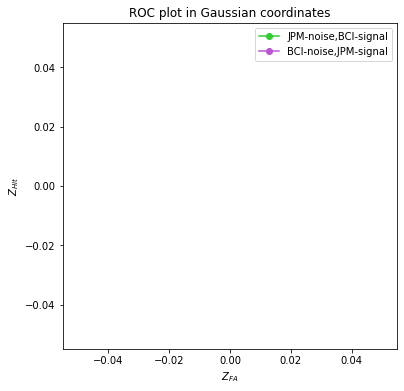

In [40]:
plt.figure(figsize=(6,6))
plt.plot(inv_p_fa,inv_p_hit,color = 'limegreen',marker='o',label='JPM-noise,BCI-signal')
plt.plot(inv_p_fa_r,inv_p_hit_r,color= 'mediumorchid',marker='o',label='BCI-noise,JPM-signal')
plt.title('ROC plot in Gaussian coordinates')
plt.xlabel('$Z_{FA}$')
plt.ylabel('$Z_{Hit}$')
plt.legend()
plt.show()

#### take AGVG as noise - JPM

In [41]:
#ABVB
mus_jpm_a_agvg, sigmas_jpm_a_agvg = get_params_AV(mu_ag_jpm, mu_vg_jpm, sigma_vh_jpm, sigma_vm_jpm,
                                sigma_vl_jpm, sigma_ah_jpm, sigma_am_jpm,
                                sigma_al_jpm,
                                sigma_0=sigma_0_a)
res_prob_jpm_a_agvg = guassian2prob(mus_jpm_a_agvg, sigmas_jpm_a_agvg, c_jpm)

Text(0.5, 1.0, 'tester index:5\nsnr:Vhi_Alo, synch:asynch')

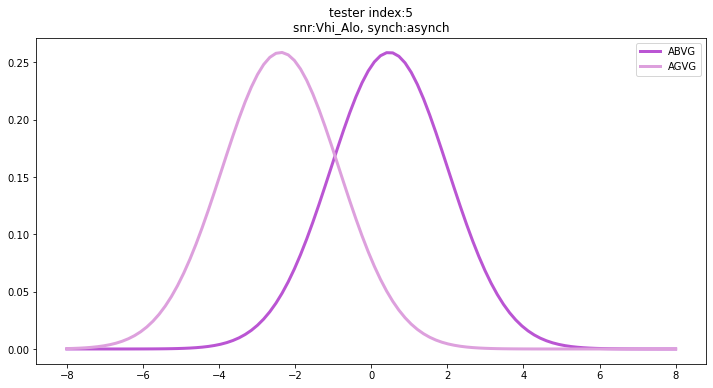

In [42]:
plt.figure(figsize=(12,6))

j=synch_type

if j == 0:
    mus_jpm = mus_jpm_s
    sigmas_jpm = sigmas_jpm_s
    res_prob_jpm = res_prob_jpm_s
    ori_prob = np.array(data['AVFus']['synch']['props'][test_index, :, :])
    p = p_s
    # title_str = sub_plot_title[i]+' synchrony'
    res_prob = res_prob_s
else:
    mus_jpm = mus_jpm_a
    sigmas_jpm = sigmas_jpm_a
#     res_prob_jpm = res_prob_jpm_a
#     ori_prob = np.array(data['AVFus']['asynch']['props'][test_index, :, :])
    p = p_a
    # title_str = sub_plot_title[i]+' asynchrony'
    res_prob = res_prob_a
    mus_jpm_agvg = mus_jpm_a_agvg
    sigmas_jpm_agvg = sigmas_jpm_a_agvg

xs = np.linspace(-PLOT_RANGE,PLOT_RANGE,100)
plt.plot(xs, stats.norm.pdf(xs, mus_jpm[snr_type], sigmas_jpm[snr_type]),
               color='mediumorchid', linewidth=3, label='ABVG')
plt.plot(xs, stats.norm.pdf(xs, mus_jpm_agvg[snr_type], sigmas_jpm_agvg[snr_type]),
               color='plum', linewidth=3, label='AGVG')


# generating samples




# plt.xlim(-5,8)
plt.legend()
plt.title('tester index:{}\nsnr:{}, synch:{}'.format(test_index,snrs_names[snr_type],synch_names[synch_type]))

In [43]:
# sample the JPM distribution
sample_jpm = np.random.normal(mus_jpm[snr_type], sigmas_jpm[snr_type], sample_size)
sample_jpm_agbg = np.random.normal(mus_jpm_agvg[snr_type], sigmas_jpm_agvg[snr_type], sample_size)

In [44]:
criterion = np.linspace(-6,8,50)
noise_sample = sample_jpm_agbg
signal_sample = sample_jpm
print(len(criterion))

50


In [45]:
p_fa = [np.sum(noise_sample > c)/sample_size for c in criterion]
p_hit = [np.sum(signal_sample > c)/sample_size  for c in criterion]
inv_p_hit = [norm.ppf(p_h) for p_h in p_hit]
inv_p_fa = [norm.ppf(p_f) for p_f in p_fa]

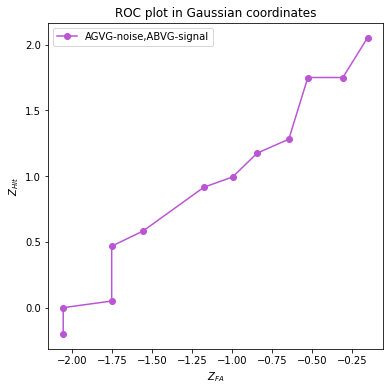

In [46]:
plt.figure(figsize=(6,6))
plt.plot(inv_p_fa,inv_p_hit,color = 'mediumorchid',marker='o',label='AGVG-noise,ABVG-signal')
# plt.plot(inv_p_fa_r,inv_p_hit_r,color= 'mediumorchid',marker='o',label='BCI-noise,JPM-signal')
plt.title('ROC plot in Gaussian coordinates')
plt.xlabel('$Z_{FA}$')
plt.ylabel('$Z_{Hit}$')
plt.legend()
plt.show()